# Exercise 07 CNN & Transfer Learning - Assignment - Solution

<span style="color:red">**The submission deadline of this assignment is 15/04/2024 23:59.**</span>

<span style="color:red">**Do not submit the saved `.pth` file of the trained CNN, because the file size is too big.**</span>

## Pedagogy

This notebook contains both theoretical explanations and executable cells to execute your code.

When you see the <span style="color:red">**[TBC]**</span> (To Be Completed) sign, it means that you need to perform an action else besides executing the cells of code that already exist. These actions can be:
- Complete the code with proper comments
- Respond to a question
- Write an analysis
- etc.

## Requirement

In this assignment, you are required to build a multi-class image classifier with pre-trained Squeeze Net using transfer learning.

The problem to be solved is to classify grayscale images into one of the 10 pre-defined classes:

![](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

|Label|0|1|2|3|4|5|6|7|8|9|
|-|-|-|-|-|-|-|-|-|-|-|
|Class|T-shit/top|Trouser|Pullover|Dress|Coat|Sandal|Shirt|Sneaker|Bag|Ankle boot|

<span style="color:red">**[TBC]**</span> Please complete the following tasks:
- Build the data pipeline
- Load pre-trained model and re-build the classifier
- Train the re-built classifier
- Test and evaluation
- (Optional) Fine-tuning entire CNN

### Import libraries

In [1]:
# import libraries
import os
import datetime
import warnings

import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import classification_report

from torch import nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split

In [2]:
# suppress all warnings
warnings.filterwarnings("ignore")

## Task 1. Build the data pipeline

You are required to use the PyTorch built-in Fashion MNIST dataset, consists of 70,000 $28\times28$ grayscale images in 10 classes, with 7,000 images per class. You can find more information about this dataset from the [PyTorch documentation](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html) and the [original source](https://github.com/zalandoresearch/fashion-mnist).

To use the Fashion MNIST dataset and the pre-trained Squeeze Net, apart from the pre-processing transformations illustrated in the Instruction notebook, you also need to convert the grayscale image to the RGB image. To do this, you can add an additional transformation `transforms.Grayscale(num_output_channels=3)` to the sequence of transformations you defined.

<span style="color:red">**[TBC]**</span> You need to:
- Define a sequence of transformations to pre-process the images
- Use `torchvision.datasets.FashionMNIST()` to load the dataset
- Divide the dataset into the training, valiation, and test set
- Create `DataLoader` instance to wrap the dataset as iterable objects
    - Decide a proper batch size considering
        - The available memory of your computer
        - The desired number of batches in each epoch

In [3]:
# define transformations required by the pre-trained SqueezeNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit SqueezeNet
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization parameters for pre-trained models
])

In [4]:
# load FashionMNIST dataset
train_val_ds = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform = transform
)
test_ds = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = transform
)
train_ds, val_ds = random_split(
    train_val_ds,
    [0.8, 0.2]
)

In [5]:
# create the train and test data loaders
batch_size = 512 # usually set to 2 to the nth power
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)

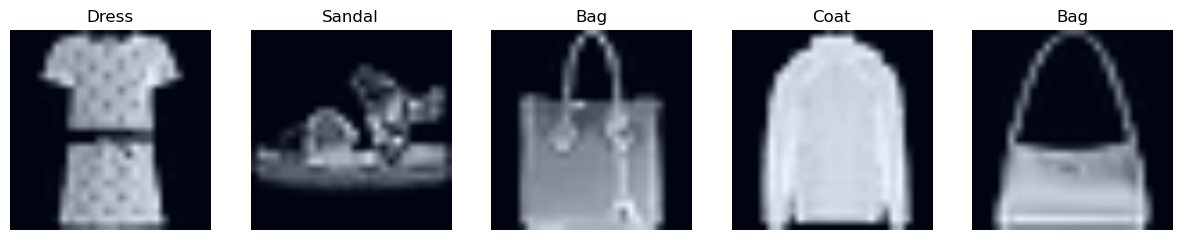

In [6]:
# define a function to display several images in the dataset
def display_dataset(dataset, n = 10,classes = None):
    fig, ax = plt.subplots(1, n, figsize = (15, 3))
    mn = min([dataset[i][0].min() for i in range(n)])
    mx = max([dataset[i][0].max() for i in range(n)])
    for i in range(n):
        ax[i].imshow(np.transpose((dataset[i][0] - mn)/(mx - mn), (1, 2, 0)))
        ax[i].axis('off')
        if classes:
            ax[i].set_title(classes[dataset[i][1]])
# class names
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress',
           'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
# display several example images
display_dataset(train_ds, n = 5, classes = classes)

## Task 2. Load Pre-trained model and Re-build the classifier 

<span style="color:red">**[TBC]**</span> You need to:
- Load the pre-trained Squeeze Net
- Replace the `classifier` part
- Freeze the `features` part
- Set up GPU acceleration if it's possible

In [7]:
# load pre-trained SqueezeNet 1.1 model
squeezenet = models.squeezenet1_1(pretrained = True)
# print network structure
print(f"Model structure:\n{squeezenet}\n")

Model structure:
SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
 

In [8]:
# replace the final FC layer
squeezenet.classifier = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(1000), nn.LazyBatchNorm1d(), nn.ReLU(), nn.Dropout(p = 0.5),
    nn.LazyLinear(100), nn.LazyBatchNorm1d(), nn.ReLU(), nn.Dropout(p = 0.5),
    nn.LazyLinear(10)
)
# print network structure
print(f"Model structure:\n{squeezenet}\n")

Model structure:
SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
 

In [9]:
# freeze the learning parameters of the feature extractor part
for parameter in squeezenet.features.parameters():
    parameter.requires_grad = False

In [10]:
# set GPU acceleration
# get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
squeezenet = squeezenet.to(device)

Using mps device


## Task 3. Train the re-built classifier

<span style="color:red">**[TBC]**</span> You need to:

- Define a `train()` function
    - Embed automatic model saving in the training process
    - <span style="color:red">**Do not submit the saved file as it will be too big.**</span>
- Specify the training hyper-parameters
- Train the network
- Reload the best model after training
- Plot the loss history of the training probess

In [11]:
# define the training function
def train(train_dl, val_dl, model, loss_fn, optimizer, epochs, early_stopping_patience, lr_scheduler):
    # initialization
    min_val_loss, patience_counter = np.inf, 0
    saved_path, start_time = '', datetime.datetime.now()
    histories = {'train_batch': [], 'train_epoch': [], 'val_batch': [], 'val_epoch': []}

    for epoch in range(epochs):
        # train
        model.train()
        train_epoch_loss = 0.0
        for X, y in tqdm(train_dl, desc = f'Training batch\t'):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            train_batch_loss = loss_fn(model(X), y)
            train_batch_loss.backward()
            optimizer.step()
            train_epoch_loss += train_batch_loss.item()
            histories['train_batch'].append(train_batch_loss.item())
        train_epoch_loss /= len(train_dl)
        histories['train_epoch'].append(train_epoch_loss)

        # validation
        model.eval()
        val_epoch_loss = 0.0
        with torch.no_grad():
            for X, y in tqdm(val_dl, desc = f'Validation batch'):
                X, y = X.to(device), y.to(device)
                val_batch_loss = loss_fn(model(X), y)
                val_epoch_loss += val_batch_loss.item()
                histories['val_batch'].append(val_batch_loss.item())
            val_epoch_loss /= len(val_dl)
            histories['val_epoch'].append(val_epoch_loss)

        # print log
        end_time = datetime.datetime.now()
        time_consumed = str(end_time - start_time).split('.')[0]
        print(f"Epoch {epoch + 1}: train loss = {train_epoch_loss:>5f}, val loss = {val_epoch_loss:>5f}, time consumed = {time_consumed}")

        # learning rate decay
        current_lr = optimizer.param_groups[0]['lr']
        lr_scheduler.step(val_epoch_loss)
        if current_lr != optimizer.param_groups[0]['lr']:
            print(f'Learning rate reduced after epoch {epoch+1}')

        # early stopping
        if val_epoch_loss < min_val_loss:
            min_val_loss, patience_counter = val_epoch_loss, 0
            if os.path.exists(saved_path):
                os.remove(saved_path)
            time_str = end_time.strftime("%Y-%m-%d_%H-%M-%S")
            saved_path = f'epoch_{epoch+1}_val_loss_{val_epoch_loss:>4f}_{time_str}.pth'
            torch.save(model.state_dict(), saved_path)
            print(f'Model saved after epoch {epoch+1}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping!')
                break
                
    return histories, saved_path

In [12]:
# define the training hyper-parameters
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-1
weight_decay = 1e-5
optimizer = torch.optim.Adam(
    squeezenet.classifier.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)
epochs = 1000
early_stopping_patience = 5
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 2
)

In [13]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    squeezenet,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler
)
# reload the best model
squeezenet.load_state_dict(torch.load(saved_path))

Validation batch: 100%|█████████████████████████| 24/24 [00:08<00:00,  2.75it/s]


Epoch 1: train loss = 0.661800, val loss = 0.417103, time consumed = 0:00:47
Model saved after epoch 1


Validation batch: 100%|█████████████████████████| 24/24 [00:08<00:00,  2.76it/s]


Epoch 2: train loss = 0.473907, val loss = 0.323282, time consumed = 0:01:33
Model saved after epoch 2


Validation batch: 100%|█████████████████████████| 24/24 [00:08<00:00,  2.74it/s]


Epoch 3: train loss = 0.413305, val loss = 0.293844, time consumed = 0:02:20
Model saved after epoch 3


Validation batch: 100%|█████████████████████████| 24/24 [00:08<00:00,  2.74it/s]


Epoch 4: train loss = 0.382940, val loss = 0.289681, time consumed = 0:03:06
Model saved after epoch 4


Validation batch: 100%|█████████████████████████| 24/24 [00:08<00:00,  2.74it/s]


Epoch 5: train loss = 0.372563, val loss = 0.275234, time consumed = 0:03:53
Model saved after epoch 5


Validation batch: 100%|█████████████████████████| 24/24 [00:08<00:00,  2.75it/s]


Epoch 6: train loss = 0.361267, val loss = 0.264588, time consumed = 0:04:40
Model saved after epoch 6


Validation batch: 100%|█████████████████████████| 24/24 [00:08<00:00,  2.74it/s]


Epoch 7: train loss = 0.364801, val loss = 0.262994, time consumed = 0:05:27
Model saved after epoch 7


Validation batch: 100%|█████████████████████████| 24/24 [00:10<00:00,  2.30it/s]


Epoch 8: train loss = 0.366964, val loss = 0.287996, time consumed = 0:06:18


Validation batch: 100%|█████████████████████████| 24/24 [00:29<00:00,  1.22s/it]


Epoch 9: train loss = 0.369526, val loss = 0.303825, time consumed = 0:08:01


Validation batch: 100%|█████████████████████████| 24/24 [00:11<00:00,  2.08it/s]


Epoch 10: train loss = 0.369388, val loss = 0.279636, time consumed = 0:09:35
Learning rate reduced after epoch 10


Validation batch: 100%|█████████████████████████| 24/24 [00:09<00:00,  2.64it/s]


Epoch 11: train loss = 0.274008, val loss = 0.208784, time consumed = 0:10:29
Model saved after epoch 11


Validation batch: 100%|█████████████████████████| 24/24 [00:08<00:00,  2.74it/s]


Epoch 12: train loss = 0.217327, val loss = 0.204901, time consumed = 0:11:17
Model saved after epoch 12


Validation batch: 100%|█████████████████████████| 24/24 [00:08<00:00,  2.72it/s]


Epoch 13: train loss = 0.204150, val loss = 0.212515, time consumed = 0:12:04


Validation batch: 100%|█████████████████████████| 24/24 [00:08<00:00,  2.73it/s]


Epoch 14: train loss = 0.200751, val loss = 0.200198, time consumed = 0:12:51
Model saved after epoch 14


Validation batch: 100%|█████████████████████████| 24/24 [00:08<00:00,  2.74it/s]


Epoch 15: train loss = 0.188966, val loss = 0.208931, time consumed = 0:13:38


Validation batch: 100%|█████████████████████████| 24/24 [00:08<00:00,  2.72it/s]


Epoch 16: train loss = 0.192810, val loss = 0.205186, time consumed = 0:14:24


Validation batch: 100%|█████████████████████████| 24/24 [00:09<00:00,  2.54it/s]


Epoch 17: train loss = 0.191636, val loss = 0.208654, time consumed = 0:15:12
Learning rate reduced after epoch 17


Validation batch: 100%|█████████████████████████| 24/24 [00:09<00:00,  2.54it/s]


Epoch 18: train loss = 0.154471, val loss = 0.190746, time consumed = 0:16:01
Model saved after epoch 18


Validation batch: 100%|█████████████████████████| 24/24 [00:08<00:00,  2.75it/s]


Epoch 19: train loss = 0.126050, val loss = 0.191710, time consumed = 0:16:48


Validation batch: 100%|█████████████████████████| 24/24 [00:08<00:00,  2.69it/s]


Epoch 20: train loss = 0.108551, val loss = 0.191915, time consumed = 0:17:36


Validation batch: 100%|█████████████████████████| 24/24 [00:09<00:00,  2.62it/s]


Epoch 21: train loss = 0.094632, val loss = 0.199117, time consumed = 0:18:26
Learning rate reduced after epoch 21


Validation batch: 100%|█████████████████████████| 24/24 [00:08<00:00,  2.70it/s]


Epoch 22: train loss = 0.084304, val loss = 0.198768, time consumed = 0:19:15


Validation batch: 100%|█████████████████████████| 24/24 [00:08<00:00,  2.73it/s]


Epoch 23: train loss = 0.084975, val loss = 0.199156, time consumed = 0:20:03
Early stopping!


<All keys matched successfully>

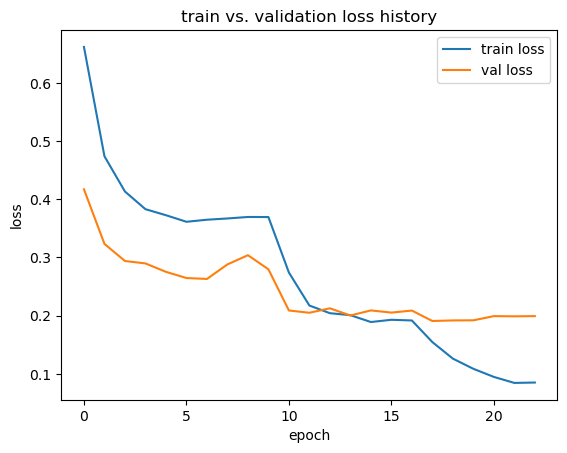

In [14]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## Step 4. Test and evaluation

<span style="color:red">**[TBC]**</span> You need to:
- Define the `test()` function
    - Output logits, probabilities and predictions
    - Output the loss value on the test set
- Make predictions on the test dataset
- Evaluate the performance
    - Use `sklearn.metrics.classification_report()`

In [15]:
# define a function to make predictions on test dataset and evaluate the performance
def test(dataloader, model, loss_fn):
    logits, probs, preds = [], [], []
    with torch.no_grad():
        loss = 0.0
        for (X, y) in tqdm(dataloader, desc = f'Test batch'):
            X, y = X.to(device), y.to(device)
            batch_logits = model(X)
            batch_loss = loss_fn(batch_logits, y)
            loss += batch_loss.item()

            batch_probs = torch.softmax(batch_logits, dim = -1)
            _, batch_preds = torch.max(batch_logits, 1)

            logits.append(batch_logits.cpu().numpy())
            probs.append(batch_probs.cpu().numpy())
            preds.append(batch_preds.cpu().numpy())
        loss /= len(dataloader)
        print(f"test loss = {loss}")
    return np.concatenate(logits), np.concatenate(probs), np.concatenate(preds), loss

In [16]:
# make prediction on test set and evaluate the performance
test_logits, test_prob, test_pred, test_loss = test(test_dl, squeezenet, loss_fn)

# obtain test labels
test_label = []
for (_, y) in test_dl:
    test_label.extend(y.cpu().numpy())

# calculate classification report
print(classification_report(test_label, test_pred, target_names = classes))

Test batch: 100%|███████████████████████████████| 20/20 [00:07<00:00,  2.67it/s]


test loss = 0.20422065258026123
              precision    recall  f1-score   support

 T-shirt/top       0.87      0.88      0.88      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.90      0.90      0.90      1000
       Dress       0.90      0.94      0.92      1000
        Coat       0.89      0.91      0.90      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.81      0.77      0.79      1000
     Sneaker       0.96      0.99      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The predicted class is: Dress
The predicted probability is: 0.9997533


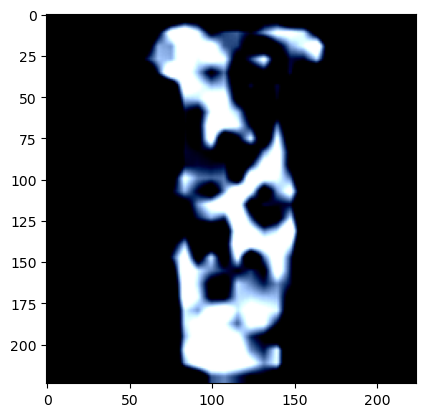

In [17]:
# display an example
plt.imshow(test_ds[100][0].numpy().transpose(1, 2, 0))
print('The predicted class is:', classes[test_pred[100]])
print('The predicted probability is:', test_prob[100, test_pred[100]])

## Optional Task. Fine-tuning entire CNN

This task is not mandatory. You need to:
- Unfreeze the `feature extractor`
- Fine-tune the entire netowrk (both the `feature extractor` and the `classifier`) with a relative small learning rate
- Reload the best model after fine-tuning
- Test and evaluation

In [18]:
# unfreeze the learning parameters of the feature extractor part
for parameter in squeezenet.features.parameters():
    parameter.requires_grad = True

In [19]:
# define the training hyper-parameters
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-5
weight_decay = 1e-5
optimizer = torch.optim.Adam(
    squeezenet.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)
epochs = 1000
early_stopping_patience = 5
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 2
)

In [20]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    squeezenet,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler
)
# reload the best model
squeezenet.load_state_dict(torch.load(saved_path))

Validation batch: 100%|█████████████████████████| 24/24 [00:08<00:00,  2.69it/s]


Epoch 1: train loss = 0.129285, val loss = 0.187844, time consumed = 0:01:22
Model saved after epoch 1


Validation batch: 100%|█████████████████████████| 24/24 [00:08<00:00,  2.70it/s]


Epoch 2: train loss = 0.122628, val loss = 0.188482, time consumed = 0:02:38


Validation batch: 100%|█████████████████████████| 24/24 [00:08<00:00,  2.69it/s]


Epoch 3: train loss = 0.118786, val loss = 0.186942, time consumed = 0:03:52
Model saved after epoch 3


Validation batch: 100%|█████████████████████████| 24/24 [00:08<00:00,  2.70it/s]


Epoch 4: train loss = 0.116616, val loss = 0.185926, time consumed = 0:05:07
Model saved after epoch 4


Validation batch: 100%|█████████████████████████| 24/24 [00:09<00:00,  2.63it/s]


Epoch 5: train loss = 0.114612, val loss = 0.186863, time consumed = 0:06:22


Validation batch: 100%|█████████████████████████| 24/24 [00:09<00:00,  2.66it/s]


Epoch 6: train loss = 0.115220, val loss = 0.185717, time consumed = 0:07:39
Model saved after epoch 6


Validation batch: 100%|█████████████████████████| 24/24 [00:09<00:00,  2.67it/s]


Epoch 7: train loss = 0.112143, val loss = 0.184321, time consumed = 0:08:57
Model saved after epoch 7


Validation batch: 100%|█████████████████████████| 24/24 [00:09<00:00,  2.66it/s]


Epoch 8: train loss = 0.110431, val loss = 0.186874, time consumed = 0:10:14


Validation batch: 100%|█████████████████████████| 24/24 [00:09<00:00,  2.66it/s]


Epoch 9: train loss = 0.107078, val loss = 0.186474, time consumed = 0:11:30


Validation batch: 100%|█████████████████████████| 24/24 [00:09<00:00,  2.62it/s]


Epoch 10: train loss = 0.107233, val loss = 0.187520, time consumed = 0:12:47
Learning rate reduced after epoch 10


Validation batch: 100%|█████████████████████████| 24/24 [00:08<00:00,  2.68it/s]


Epoch 11: train loss = 0.104266, val loss = 0.186763, time consumed = 0:14:02


Validation batch: 100%|█████████████████████████| 24/24 [00:09<00:00,  2.65it/s]

Epoch 12: train loss = 0.103057, val loss = 0.186493, time consumed = 0:15:18
Early stopping!


<All keys matched successfully>

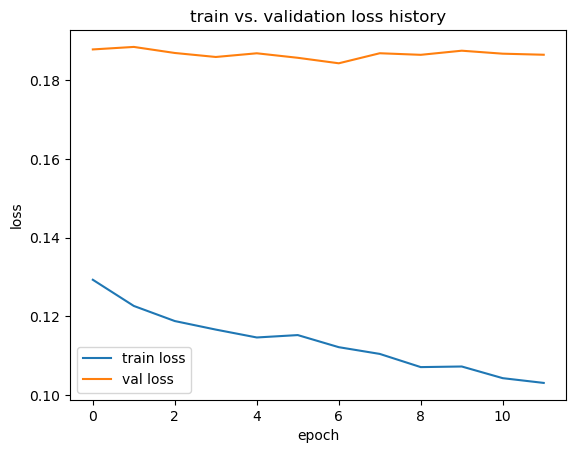

In [21]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [22]:
# make prediction on test set and evaluate the performance
test_logits, test_prob, test_pred, test_loss = test(test_dl, squeezenet, loss_fn)

# obtain test labels
test_label = []
for (_, y) in test_dl:
    test_label.extend(y.cpu().numpy())

# calculate classification report
print(classification_report(test_label, test_pred, target_names = classes))

Test batch: 100%|███████████████████████████████| 20/20 [00:07<00:00,  2.69it/s]


test loss = 0.1955396942794323
              precision    recall  f1-score   support

 T-shirt/top       0.87      0.89      0.88      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.90      0.92      0.91      1000
       Dress       0.91      0.95      0.93      1000
        Coat       0.90      0.90      0.90      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.83      0.78      0.80      1000
     Sneaker       0.97      0.98      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.97      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

